In [1]:

import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import torch

from copy import deepcopy
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from typing import Tuple, Optional, List
from tqdm import tqdm


# Torch imports
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision

from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision.datasets.folder import default_loader as loader 

# labml imports
from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs
from labml_nn.diffusion.ddpm import DenoiseDiffusion
from labml_nn.diffusion.ddpm.unet import UNet
# from labml_nn.diffusion.ddpm.experiment import Configs
from labml_nn.diffusion.ddpm.utils import gather

# Diffusion for Dynamics Model
This notebook is for using diffusion models to sample the next state in each step
Main steps will be as follows: 
1. Train a `eps_model` to predict the noise in the diffusion model
2. Also there will be an `MSE` loss between the generated position and the next position

## Model Implementations

In [2]:
class EpsModel(nn.Module): # It will get 2 values for position and 1 binary flag to indicate if the input is a dog or a box
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, hidden_shape),
            nn.ReLU(),
            nn.Linear(hidden_shape, output_shape) # Output shape will be two values (x and y)
        )

    def forward(self, x, t):
        # Add another dimension to t
        t = t.reshape(x.shape) # They technically should have the same shape
        out = torch.cat((x,t), dim=-1)
        return self.model(out)

# Optimizer will be used to train this model

In [3]:
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps # Number of steps to noise and denoise the data
        self.sigma2 = self.beta

    def gather(self, consts: torch.Tensor, t: torch.Tensor):
        c = consts.gather(-1, t)
        return c.reshape(-1, 1)

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = self.gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - self.gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        alpha_bar = self.gather(self.alpha_bar, t)
        alpha = self.gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = self.gather(self.sigma2, t)

        eps = torch.randn(xt.shape, device=xt.device)
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        if noise is None:
            noise = torch.randn_like(x0)

        xt = self.q_sample(x0, t, eps=noise) # t times noised version for random different ts

        ''' 
        TODO:
        xnext_t = self.q_sample(x_0, t, eps=noise_next) - BURDA CONDITIONAL BIR SEYE IHTIYACIN OLUCAK
        x_t = self.q_sample(x_0, t, eps=noise_curr)
        eps_theta = self.eps_model(x_t, t) 
        F.mse_loss(noise_next, eps_theta) - x_tyi oyle bi temizlicek ki 
        '''
        eps_theta = self.eps_model(xt, t) # Ikisini de q_sample'a sokucaksin

        return F.mse_loss(noise, eps_theta)

## Diffusion with Mock Data
We will do these things with the mock data first

### Mock Data Creation
There will be mock first and next data.


They will be two gaussian distributions with two different means

In [4]:
# Method to plot gaussian distribution with the given data
# It will first find the mean and std of the given data
# then it will plot it
def plot_gaus_dist(x, ax, label):
    traj_len = len(x)

    mean = x.mean()
    std = x.std()

    lin_range = np.linspace(mean-std*2, mean+std*2, traj_len)
    ax.plot(lin_range, stats.norm.pdf(lin_range, mean, std), label=label)
    ax.legend()


In [5]:
class MockDist(data.Dataset):
    def __init__(self, mean, std, dataset_size):
        self.mean = mean 
        self.std = std 
        self.dataset_size = dataset_size
        self.data = np.random.normal(self.mean, self.std, self.dataset_size)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, index):
        return torch.FloatTensor([self.data[index]])

In [6]:
curr_z_dset = MockDist(mean=1,std=3, dataset_size=10000)

In [7]:
next_z_dset = MockDist(mean=2,std=5, dataset_size=10000)
# next_z.show()

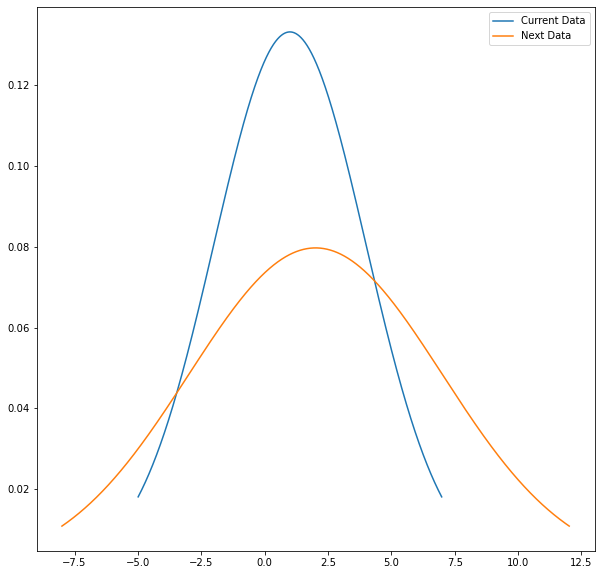

In [8]:
nrows = 1
ncols = 1
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), ncols=ncols, nrows=nrows)
plot_gaus_dist(curr_z_dset.data, axs, label='Current Data')
plot_gaus_dist(next_z_dset.data, axs, label='Next Data') 

### Use Diffusion Model to Generate one of the Distributions
First step is to generate one of the distributions (let's say `curr_z` only for now)

In [44]:
# Initialize the models
device = torch.device('cuda:0')
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 200
N_SAMPLES = 10000 # Number of values to sample when we sample from diffusion
N_STEPS = 1000
eps_model = EpsModel(2,16,1).to(device) # Input shape: 1 for number 1 for timestep of the noise
diffusion = DenoiseDiffusion(
    eps_model=eps_model,
    n_steps=N_STEPS, # Number of steps to noise the data
    device=device # This model should be able to be trained on CPU
)
optimizer = torch.optim.Adam(params=eps_model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=WEIGHT_DECAY)


In [45]:
# Initialize the dataset and the dataloader
curr_dataloader = data.DataLoader(curr_z_dset, batch_size=32, shuffle=True, num_workers=4)

In [46]:
losses = []
ncols = 10
nrows = math.ceil(EPOCHS / 10)
print('nrows: {}'.format(nrows))
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), nrows=nrows, ncols=ncols)
pbar = tqdm(total=EPOCHS)
for i in range(EPOCHS):
    axs_row = int(i / ncols)
    axs_col = int(i % ncols)
    # print('axs_row: {}, axs_col: {}'.format(axs_row, axs_col))

    epoch_loss = 0
    for batch in curr_dataloader:
        optimizer.zero_grad()
        x = batch.to(device)
        loss = diffusion.loss(x)
        # NOTE": Make sure the losses are scaled equaly
        loss.backward() # Will train the eps_model
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss/len(curr_z_dset)
    losses.append(avg_loss)

    pbar.update(1)
    pbar.set_description(f'Epoch: {i}, Loss: {avg_loss}, [{axs_row},{axs_col}]')

    # Sample 1k data from learned distribution - it should get closer and closer to the curr_z distribution
    # Get a random noise
    x = torch.randn((N_SAMPLES, 1), device=device)
    for t_ in range(N_STEPS):
        t = N_STEPS - t_ - 1
        x = diffusion.p_sample(x, x.new_full((N_SAMPLES,), t, dtype=torch.long))

    # print('curr_z_dset.data.shape: {}'.format(curr_z_dset.data.shape))
    # print('x.shape: {}'.format(x.shape))
    axs[axs_row, axs_col].set_title("Sampled Data in Epoch {}".format(i))
    plot_gaus_dist(curr_z_dset.data, axs[axs_row, axs_col], label='Current Data') 
    plot_gaus_dist(x[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Sampled Data')


pbar.close() 

nrows: 20


Epoch: 199, Loss: 0.015430704429745675, [19,9]: 100%|██████████| 200/200 [03:35<00:00,  1.08s/it]


In [33]:
print(axs.shape)

(20, 10)


In [38]:
pbar.close()

Epoch: 2, Loss: 0.1826048152565956, [0,2]:   2%|▏         | 3/200 [00:05<06:06,  1.86s/it]


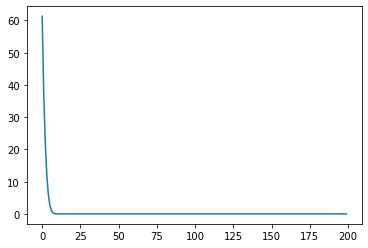

In [42]:
plt.plot(losses)

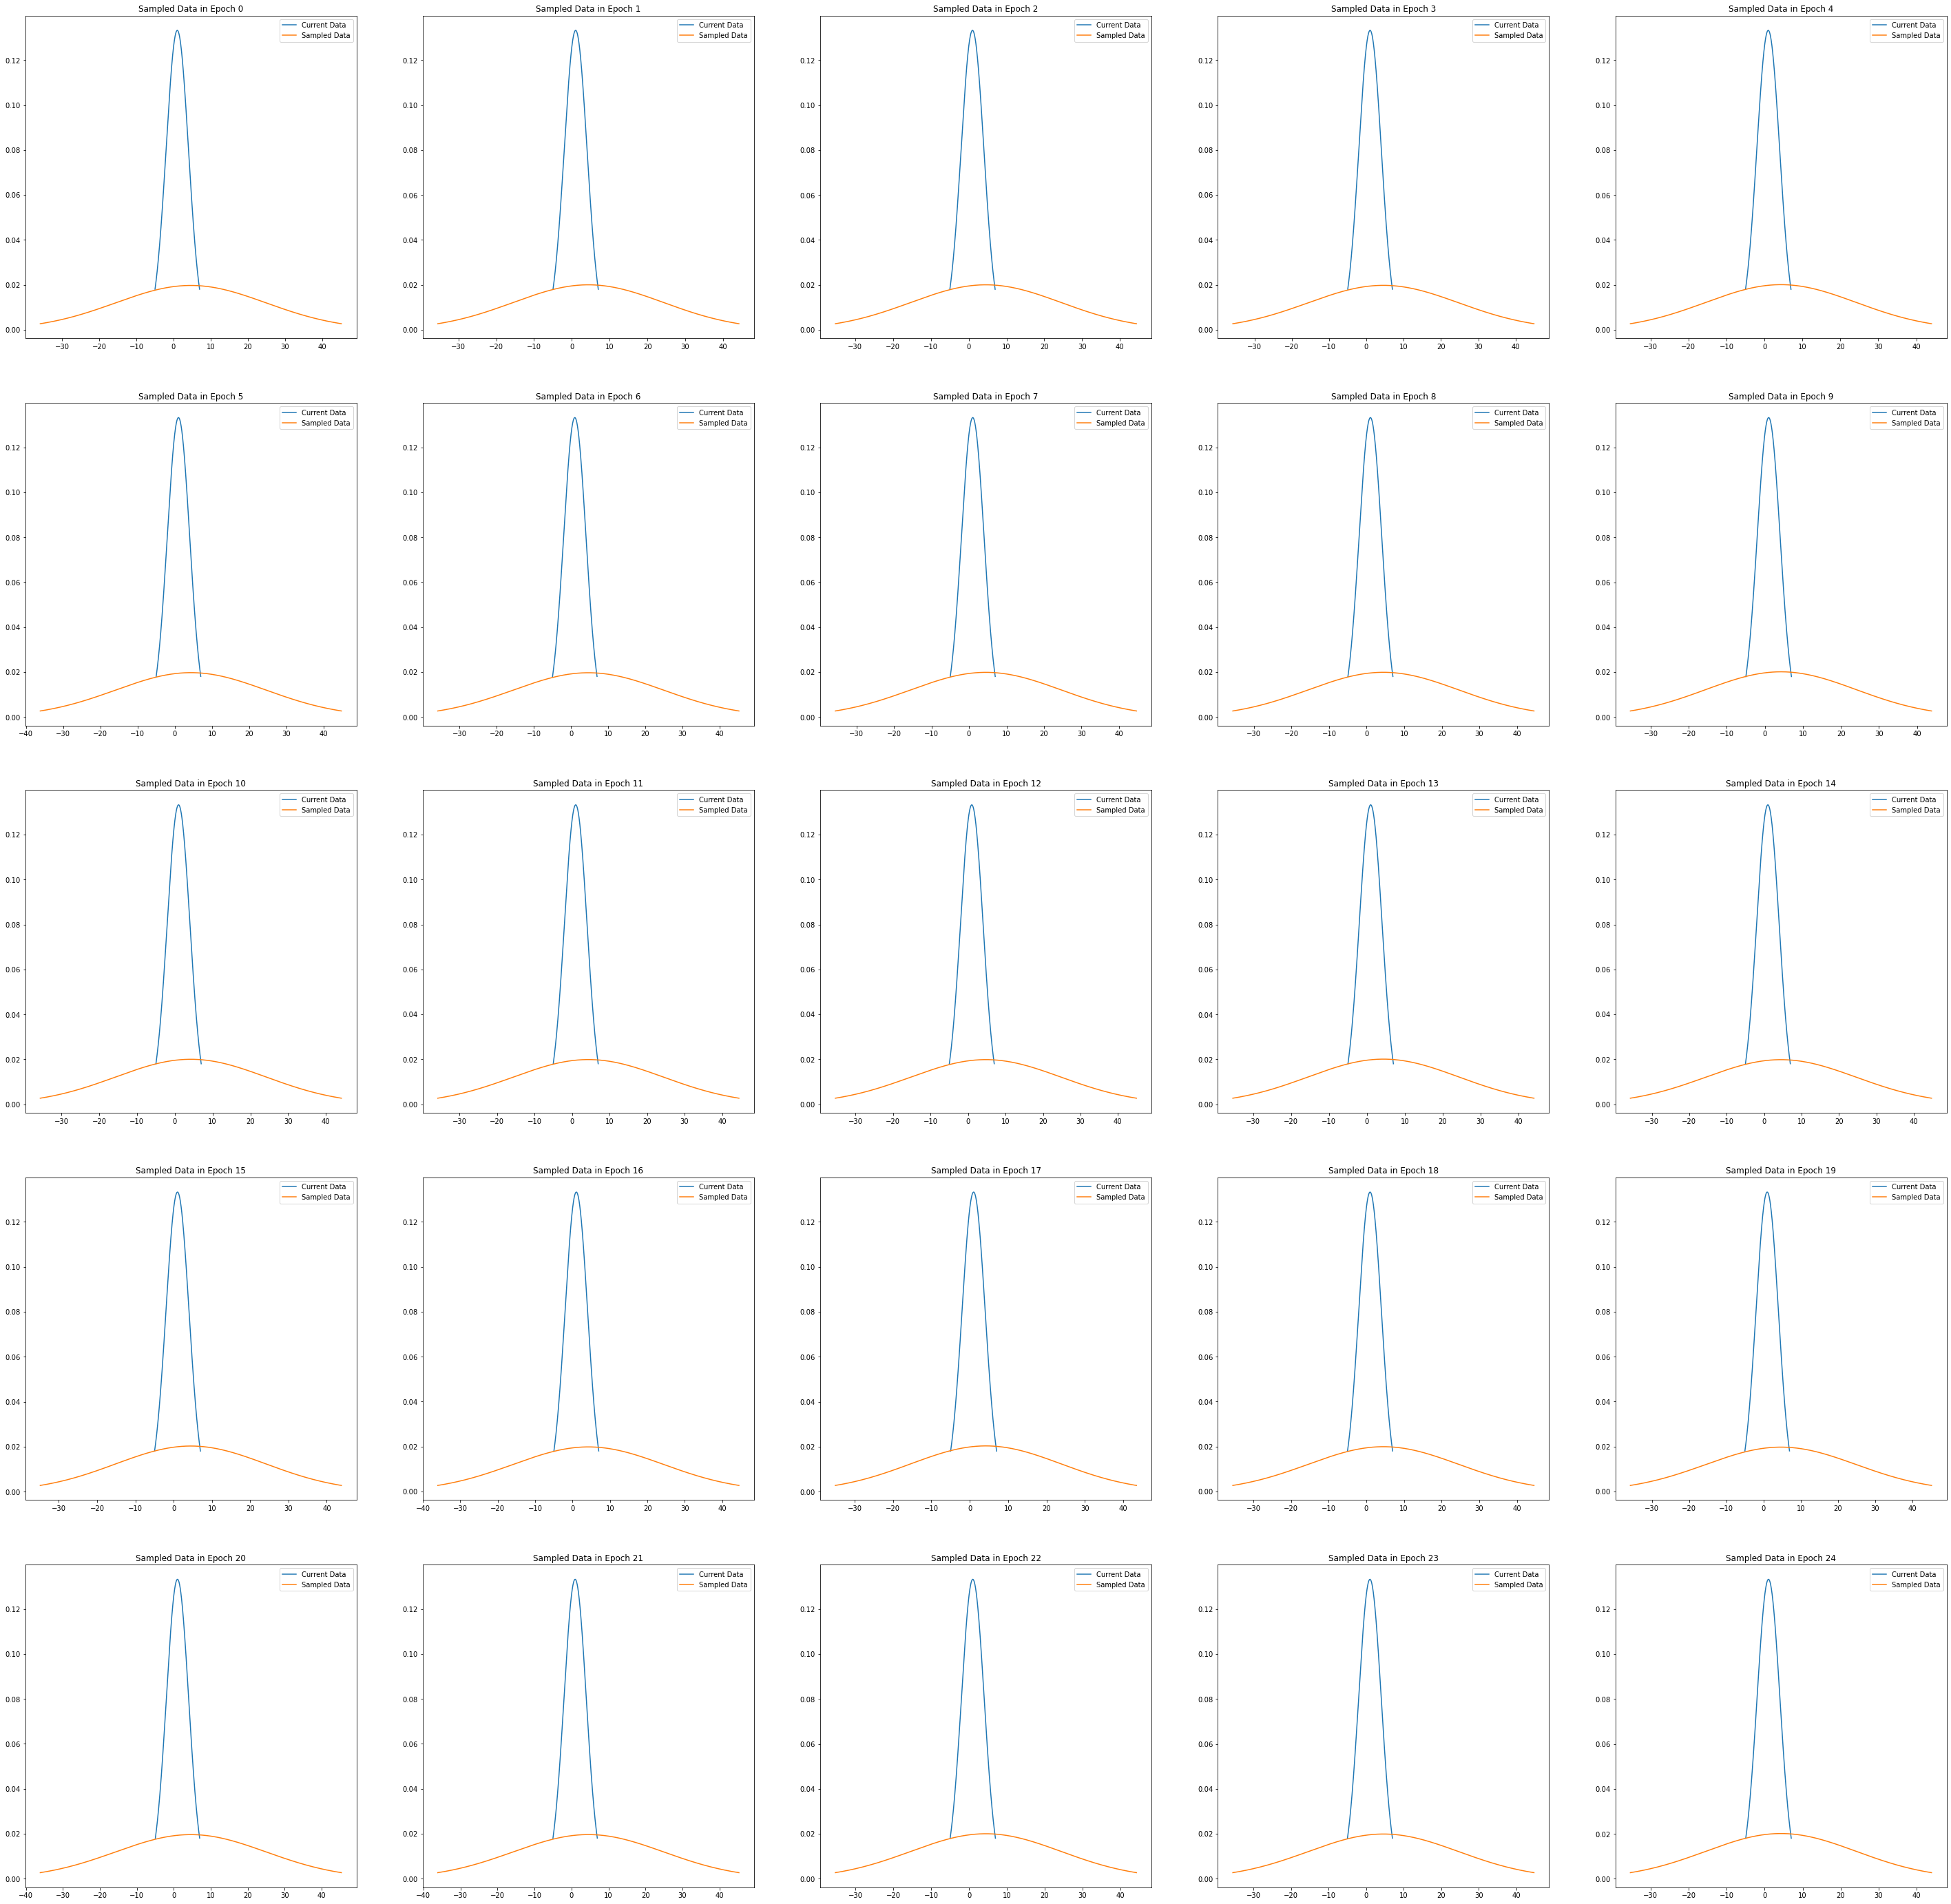

In [43]:
ncols = 5
nrows = 5
fig, axs = plt.subplots(figsize=(10*ncols, 10*nrows), nrows=nrows, ncols=ncols)
for i in range(25):
    axs_row = int(i / ncols)
    axs_col = int(i % ncols)
    
    x = torch.randn((N_SAMPLES, 1), device=device)
    for t_ in range(N_STEPS):
        t = N_STEPS - t_ - 1
        x = diffusion.p_sample(x, x.new_full((N_SAMPLES,), t, dtype=torch.long))

    # print('curr_z_dset.data.shape: {}'.format(curr_z_dset.data.shape))
    # print('x.shape: {}'.format(x.shape))
    axs[axs_row, axs_col].set_title("Sampled Data in Epoch {}".format(i))
    plot_gaus_dist(curr_z_dset.data, axs[axs_row, axs_col], label='Current Data') 
    plot_gaus_dist(x[:,0].cpu().detach().numpy(), axs[axs_row, axs_col], label='Sampled Data')